# Backprop своими руками

Материалы:

* [Andrew Karpahy: yes, you should understand backprop](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)
* [Stanford CS231n](http://cs231n.stanford.edu/)
* [Deep Learning](http://sereja.me/f/deep_learning_goodfellow.pdf) — с 204 страницы и до прозрения
* [Xavier, Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

<img width='800px' src='https://cdn-images-1.medium.com/max/1600/1*q1M7LGiDTirwU-4LcFq7_Q.png'>

Иногда сети пишут на чистом C++, причём код для обучения и инференса (реального прогона в продакшне) — отдельно. Так делают, когда нужен очень быстрый отклик и высокая производительность, но это очень трудоемко.

Большинство людей не усложняют себе жизнь и просто используют фреймворки — с ними можно просто почти декларативно описать, какие операции хотите сделать с данными, а он потом сам построит сеть и подгонит её под данные.

Ваше задание — реализовать свой небольшой фреймворк глубокого обучения на чистом `numpy`. Основное время у вас должно уйти на вывод формул для градиентов, анализ поведения самых часто используемых слоев в современных нейросетях и прочий матан. Хотя бы один раз в жизни это надо сделать, а уже потом пользоваться готовыми абстракциями.

Предполагаемый порядок выполнения:
* Поймите на высоком уровне, как работает алгоритм backpropagation
* Изучите пример с логиситической регрессией, чтобы понять, что от вас в итоге хотят
* Изучите код `Module`
* `Sequential`
* `Linear`
* `SoftMax`
* `CrossEntropy`
* Протестируйте их на логситической регрессии
* Напишите код для решения MNIST
* Дописывайте остальные слои, пока не получите на нём 97%

Оценивание (суммарно до 20 баллов):
* 5 баллов -- что-то хоть как-то обучается, MNIST на валидации >90%
* 2 балла -- MNIST на 95%, дальше по одному баллу за 96%, 97% и 98%. Это будет сделать намного сложнее, чем через PyTorch, потому что вам всё нужно писать самим: более сложные оптимизаторы, learning rate decay, думать про численную стабильность и т. д.
* По 2 балла за слои: LeakyReLU, Dropout, BatchNorm, CrossEntropy, SoftMax

Советы:
* Чтобы лучше понять, что должно в итоге получиться, изучите «игрушечный пример» и вообще эту тетрадку, а потом начните читать `hw_framework.py`, где будет более техничное описание.
* Для дебага проверяйте градиенты численно — сдвигайте параметры на какой-нибудь эпсилон и смотрите разницу. Ещё можете проверить, что на одинаковых данных они дают то же, что их эквиваленты из PyTorch (можно после каждого нового слоя добавить юнит тест через `assert`).
* Пишите код без циклов — в питоне они очень долгие; все вычисления можно делать внутри numpy.
* Ограничение на срок сдачи большое — до конца всего курса, но рекомендуется закончить примерно за месяц. Дописывайте его постепенно, разбираясь, как работает каждая функция активации.
* Обсуждайте математику и общую архитектуру фреймворка, но не шарьте друг другу код — так не интересно.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---

Откройте в Jupyter две тетрадки — эту и `hw_framework.ipynb`. В этой содержится train loop, а там непосредственно ваш «фреймворк», который вам ещё предстоит написать.

Архитектура фреймворка вдохновлена PyTorch. Как всегда, если придумаете какой-то более клёвый дизайн — можете использовать его.

In [2]:
%run hw_framework.ipynb

CPU times: total: 93.8 ms
Wall time: 94.1 ms
CPU times: total: 15.6 ms
Wall time: 16 ms


c:\Users\USER\anaconda3\envs\ml_dl\lib\site-packages\IPython\core\interactiveshell.py:2294: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = fn(*args, **kwargs)


Мы будем использовать самый простой вариант градиентного спуска: просто пройдемся по всем параметрам и сделаем шаги в сторону уменьшения посчитанного заранее градиента.

Есть [более продвинутые методы](http://ruder.io/optimizing-gradient-descent/), но пока что мы их использовать не будем.

In [3]:
def SGD(params, gradients, lr=1e-3):
    for weights, gradient in zip(params, gradients):
        weights -= lr * gradient

Cоздадим обертку вокруг нашего датасета (просто numpy-евские массивы), которую будем потом использовать, чтобы итерироваться по нему.

In [4]:
def loader(X, Y, batch_size):    
    n = X.shape[0]

    # в начале каждой эпохи будем всё перемешивать
    # важно, что мы пермешиваем индексы, а не X
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        # в конце нам, возможно, нужно взять неполный батч
        end = min(start + batch_size, n)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

В следующих двух секциях — игрушечные примеры регрессии и классификации на синтезированных данных. В них ничего менять не надо — они нужны, чтобы отдебажить ваши слои в `hw_framework`.

# Линейная регрессия

In [5]:
n = 1000

X = np.random.randn(n, 10)
true_w = np.random.randn(10, 1)
Y = np.dot(X, true_w).reshape(n, 1) + np.random.randn(n, 1)/5


In [8]:
X.shape, Y.shape

((1000, 10), (1000, 1))

### Модель

In [9]:
model = Sequential(
    Linear(10, 1),
)

criterion = MSE()

Можете тут потом тестировать остальные свои слои, когда их напишите.

### Обучение

In [10]:
epochs = 10
batch_size = 10
learning_rate = 1e-1

7.08325038039329
6.704294497330935
6.579049999943031
3.636719159579601
2.278751526628701
1.4036667799854352
1.3050261574496422
1.2546965958901215
1.2168885907968612
0.42897415327756583
0.4108261559992249
0.2934931804635456
0.054301663901606526
0.21087261702284837
0.05431050188789649
0.06709238822521188
0.13850655746712393
0.1454858574977825
0.04932650528574372
0.028880041224673088
0.07817803497371802
0.07162051096556063
0.03800369632134318
0.07083103674583871
0.10045868972247418
0.10023065769342712
0.05577052326008238
0.057268037374740996
0.09875171004368552
0.07424048387740638
0.018113336504248453
0.024775989442736998
0.039976069207592294
0.04016346596950789
0.03177969665327374
0.03237617817920509
0.02904156863915272
0.03411342527833386
0.058604994592295824
0.03721446833275789
0.05806497025871142
0.05779979589755317
0.059262746727132075
0.03944780223094911
0.04231445798494156
0.02998475838162919
0.030164483620097566
0.09417426349468627
0.051256101493273254
0.023541357304016117
0.05873

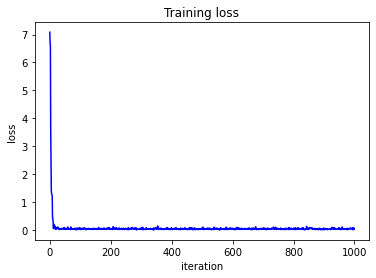

In [11]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward -- считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        
        #print(y_pred, y_true)
        #print('SUM OF SQUARES:', np.mean(np.power(y_pred-y_true, 2)))
    
        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        #print(model.layers[0].W[0][0])
        print(loss)
        
        history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

# Логистическая регрессия

Этот пример нужнен для теситрования классификации (`CrossEntropy` и `SoftMax`).

Возьмем в качестве датасета точки из двух гауссиан на плоскости.

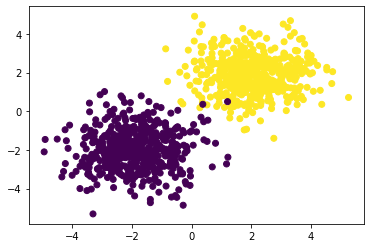

In [12]:
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)])[:, None]
Y = np.hstack([Y, 1-Y])

plt.scatter(X[:,0], X[:,1], c=Y[:,0])
plt.show()

In [15]:
Y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [14]:
X.shape, Y.shape

((1000, 2), (1000, 2))

Обратите внимание на `y`. Он в формате one-hot: у каждого вектора все нули, кроме одной единицы.

Выходные данные в таком формате упростят написание `CrossEntropy`.

### Модель

Логистическая регрессия — это тоже как бы маленькая нейронка: линейный слой, софтмакс, и максимизируем правдоподобие.

In [16]:
model = Sequential(
    Linear(2, 2),
    SoftMax()
)

criterion = CrossEntropy()

### Обучение

In [17]:
epochs = 10
batch_size = 16
learning_rate = 1e-2

0.3392973665617671
0.2640373157621617
0.21620685792508698
0.1908372414849529
0.15669265205634492
0.17376176919954384
0.13952617786048493
0.14241755673326323
0.1600357063162886
0.18533398510702892
0.11203258564104451
0.15628394504729898
0.12186274815624296
0.1843962094224832
0.11345475335112551
0.12572768617578933
0.08311047989565742
0.11052579350314341
0.10094334747660061
0.10904023457780682
0.1241510279002345
0.13885681134416408
0.0984339000454226
0.09852186645915888
0.10841915453560126
0.07858624180189018
0.061872805814222456
0.13642237805261007
0.09538168969682279
0.08143031566431391
0.09616465125996337
0.10166913980791523
0.09289695231794945
0.06486381353637591
0.0549733348103601
0.03527734180683548
0.08831115605061318
0.04689346826384956
0.0508272280824368
0.0629006001697982
0.04419058101079152
0.05078614788046841
0.08211474336082536
0.11977780939240487
0.06936828774518132
0.0792344055188908
0.07021881530295015
0.07350719328271145
0.0720106316709551
0.0882704164681434
0.1341985504

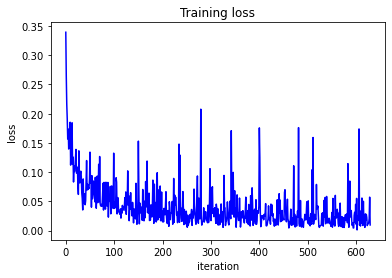

In [18]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward: считаем все значения до функции потерь
        y_pred = model.forward(x)

        loss = criterion.forward(y_pred, y_true)

        # backward: считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        # логгируем лосс
        print(loss)
        history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

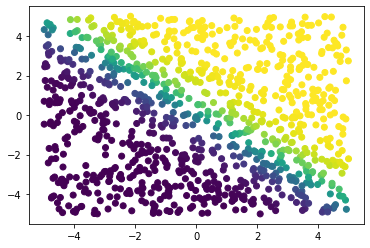

In [20]:
X_test = np.random.uniform(-5, 5, (n, 2))
y_test = model.forward(X_test)

plt.scatter(X_test[:,0], X_test[:,1], c=y_test[:,0])
plt.show()

Мы тут пропустили много важных деталей: валидация, подсчет точности (кроссэнтропия не очень информативна), регуляризация. Вам всё это нужно будет реализовать потом самим.

# Теперь сами

In [6]:
import os
from sklearn.datasets import fetch_openml
# эти библиотеки нужны только для того, чтобы скачать MNISt

if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r', allow_pickle=True) as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_openml("mnist_784")
    # очень важно его отнормировать -- см. Linear в hw_framework
    X = mnist.data / 255.0
    y = mnist.target
    np.savez('mnist.npz', X=X, y=y)

In [7]:
X.shape, y.shape

((70000, 784), (70000,))

In [8]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

Переведите лейблы в one-hot.

In [10]:
true = y.copy()
true = true.astype('int')

In [11]:
mask = np.zeros((true.size, true.max() + 1))
mask[np.arange(true.size), true] = 1
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Разделите датасет на train и validation.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, mask, test_size=0.1)

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((63000, 784), (63000, 10), (7000, 784), (7000, 10))

Теперь напишите модель и train loop. Можете начать с адаптации предыдущего примера.

Дальше начинается творческая часть и настоящий Deep Learning:
* поиграйтесь с архитектурами;
* поиграйтесь с learning rate и batch_size;
* сделайте learning rate decay;
* сделайте data augmentation.

Have fun. Дедлайн — не две недели, а до конца курса.

In [40]:
# Реализация из первой домашки. One-hot-encoding приводится к обычному вектору ответов

def accuracy(model, val):
    model.eval()
    total = 0
    correct = 0
    for x, y in val:
        x = x.reshape(-1, 784)
        res = model.forward(x)
        res = res.argmax(axis=1)
        y = y.argmax(axis=1)
        total += res.shape[0]
        correct += (res == y).sum()
    model.train()
    return correct / total

In [37]:
EPOCH = 100
BATCH_SIZE = 64
LR = 1e-3

model = Sequential(
    Dropout(),
    Linear(28*28, 128),
    ReLU(),
    Linear(128, 64),
    ReLU(),
    Linear(64, 10),
    ReLU(),
    SoftMax()
)

criterion = CrossEntropy()

In [16]:
def draw(input):
    fig = plt.figure
    plt.imshow(input.reshape(28, 28), cmap='gray')
    plt.show()

### Source: https://towardsdatascience.com/neural-network-optimizers-from-scratch-in-python-af76ee087aab

In [32]:
# ADAM
class MomentumOptimizer:
    def __init__(self, lr=1e-3, momentum=0.5):
        self.lr = lr
        self.previous_updates = None
        self.learning_rate = lr
        self.momentum = momentum

    def step(self, params, gradients):
        updated_params,  prevs = [], []
        if self.previous_updates is None:
            self.previous_updates = [0] * len(gradients)
     
        for param, gradients, prev_update in zip(params, gradients, self.previous_updates):            
            delta = self.lr * gradients - self.momentum * prev_update
            param -= delta 
                
            prevs.append(delta)
            updated_params.append(param)
                
        self.previous_updates = prevs

In [33]:
class AdamOptimizer:
    def __init__(self, lr):
        self.m = None
        self.v = None
        self.t = 1
        self.learning_rate = lr
        
    def step(self, params, grads, beta1 = 0.9, beta2 = 0.999):
        updated_params = []
        if self.m is None and self.v is None:
            self.m = [0] * len(grads)
            self.v = [0] * len(params)
        
        for i, (param, grad) in enumerate(zip(params, grads)):
          
          self.m[i] = beta1 * self.m[i] + (1-beta1) * grad          
          self.v[i] = beta2 * self.v[i] + (1-beta2) * grad **2
          m_corrected = self.m[i] / (1-beta1**self.t)
          v_corrected = self.v[i] / (1-beta2**self.t)
          param += -self.learning_rate * m_corrected / (np.sqrt(v_corrected) + 1e-8)
          updated_params.append(
            param 
          )
          
        self.t +=1

In [18]:
# Classic SGD

for epoch in range(EPOCH):
    for x, y in loader(X_train, y_train, BATCH_SIZE):
        x = x.reshape(-1, 784)
        out = model.forward(x)

        loss = criterion.forward(out, y)
        grad = criterion.backward(out, y)

        model.backward(x, grad)

        SGD(model.parameters(), model.grad_parameters(), LR)

    print(f'Epoch: {epoch + 1}, accuracy: {accuracy(model, loader(X_test, y_test, BATCH_SIZE))}')

Epoch: 1, accuracy: 0.30842857142857144
Epoch: 2, accuracy: 0.4217142857142857
Epoch: 3, accuracy: 0.5018571428571429
Epoch: 4, accuracy: 0.4441428571428571
Epoch: 5, accuracy: 0.43642857142857144
Epoch: 6, accuracy: 0.634
Epoch: 7, accuracy: 0.6764285714285714
Epoch: 8, accuracy: 0.6997142857142857
Epoch: 9, accuracy: 0.7141428571428572
Epoch: 10, accuracy: 0.7358571428571429
Epoch: 11, accuracy: 0.7642857142857142
Epoch: 12, accuracy: 0.7775714285714286
Epoch: 13, accuracy: 0.7934285714285715
Epoch: 14, accuracy: 0.801
Epoch: 15, accuracy: 0.8091428571428572
Epoch: 16, accuracy: 0.813
Epoch: 17, accuracy: 0.8164285714285714
Epoch: 18, accuracy: 0.822
Epoch: 19, accuracy: 0.8255714285714286
Epoch: 20, accuracy: 0.8254285714285714
Epoch: 21, accuracy: 0.8298571428571428
Epoch: 22, accuracy: 0.8304285714285714
Epoch: 23, accuracy: 0.8324285714285714
Epoch: 24, accuracy: 0.837
Epoch: 25, accuracy: 0.8388571428571429
Epoch: 26, accuracy: 0.8408571428571429
Epoch: 27, accuracy: 0.843
Epoch

In [39]:
# Momentum SGD
optimizer = MomentumOptimizer(lr=LR)

for epoch in range(EPOCH):
    for x, y in loader(X_train, y_train, BATCH_SIZE):
        x = x.reshape(-1, 784)
        out = model.forward(x)

        loss = criterion.forward(out, y)
        grad = criterion.backward(out, y)

        model.backward(x, grad)

        optimizer.step(model.parameters(), model.grad_parameters())
        #SGD(model.parameters(), model.grad_parameters(), LR)

    print(f'Epoch: {epoch + 1}, accuracy: {accuracy(model, loader(X_test, y_test, BATCH_SIZE))}')

Epoch: 1, accuracy: 0.31614285714285717
Epoch: 2, accuracy: 0.3968571428571429
Epoch: 3, accuracy: 0.38871428571428573
Epoch: 4, accuracy: 0.37457142857142856
Epoch: 5, accuracy: 0.373
Epoch: 6, accuracy: 0.36014285714285715
Epoch: 7, accuracy: 0.39057142857142857
Epoch: 8, accuracy: 0.41228571428571426
Epoch: 9, accuracy: 0.4625714285714286
Epoch: 10, accuracy: 0.5218571428571428
Epoch: 11, accuracy: 0.5412857142857144
Epoch: 12, accuracy: 0.5515714285714286
Epoch: 13, accuracy: 0.5738571428571428
Epoch: 14, accuracy: 0.6234285714285714
Epoch: 15, accuracy: 0.6327142857142858
Epoch: 16, accuracy: 0.6367142857142858
Epoch: 17, accuracy: 0.6495714285714286
Epoch: 18, accuracy: 0.7007142857142856
Epoch: 19, accuracy: 0.7204285714285714
Epoch: 20, accuracy: 0.7821428571428573
Epoch: 21, accuracy: 0.804142857142857
Epoch: 22, accuracy: 0.8135714285714286
Epoch: 23, accuracy: 0.8181428571428571
Epoch: 24, accuracy: 0.8232857142857144
Epoch: 25, accuracy: 0.8254285714285714
Epoch: 26, accura